In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from kerastuner import RandomSearch
import matplotlib.pyplot as plt
import keras_tuner as kt



import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('data_ml.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
index_last_20 = df.index[-20:]

We start with the the application of `MinMaxScaler` to both features and target variables, standardizing the data to ensure all inputs operate on a similar scale. This harmonization is essential for optimizing the model's learning process. Data is then reshaped into a sequence format suitable for LSTM models through a custom function, enabling the model to capture the temporal dependencies intrinsic to the time series data. The crux of this methodology lies in building a neural network model and refining its architecture through hyperparameter tuning. Utilizing `kt.RandomSearch`, the procedure explores a range of hyperparameters for LSTM layers (between 2 and 20 layers), units per layer (from 30 to 50 units in steps of 10), and learning rates (options of 0.01, 0.001, or 0.0001), aiming to minimize validation loss. These ranges were chosen based on common practices in machine learning, providing a broad yet practical spectrum for identifying configurations that balance model complexity and computational efficiency.

This deliberate and systematic exploration culminates in pinpointing the optimal model configuration, which is then evaluated on the validation set using RMSE to ascertain its forecasting precision. By intertwining data preprocessing, feature engineering, and advanced machine learning strategies within this structured approach, a robust framework for time series forecasting is established, demonstrating the efficacy of combining meticulous data handling with strategic hyperparameter optimization to achieve superior predictive performance.

In [ ]:
# Specify the features to use and drop the index
features = df.drop(['op_nxt', 'hi_nxt', 'lo_nxt', 'cl_nxt'], axis=1).reset_index(drop=True)

# Separate the target variable and drop the index
targets = df['op_nxt'].reset_index(drop=True)

# Split the data
# Separate out the test data
X_test = features[-40:]  # Most recent 40 days for testing
y_test = targets[-40:]  # Corrected to match X_test size

# Drop the last 40 records from the original data for training/validation
X = features[:-40]
y = targets[:-40]

# Split the remaining data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create scaler objects
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler objects on the TRAINING data
scaler_X.fit(X_train)
scaler_y.fit(y_train.values.reshape(-1, 1))

# Transform the training, validation, and test sets
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))  # Correctly scale y_test

# Function to reshape data for time series forecasting
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Reshape to [samples, time_steps, n_features]
time_steps = 20
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled.flatten(), time_steps)
X_val, y_val = create_dataset(X_val_scaled, y_val_scaled.flatten(), time_steps)
X_test, y_test = create_dataset(X_test_scaled, y_test_scaled.flatten(), time_steps)  # Corrected reshape process for y_test

# Define the model building function for the tuner
def build_model(hp):
    model = keras.Sequential()

    # Tune the number of units in the LSTM layers and choose an optimal value between 30 and 50.
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(LSTM(units=hp.Int('units_' + str(i), min_value=30, max_value=50, step=10),
                       activation='relu',
                       return_sequences=True if i < hp.get('num_layers') - 1 else False))  # Ensure correct return_sequences setup

    model.add(Dense(1))  # Corrected Dense layer reference

    # Choose an optimal learning rate for the optimizer from 0.01, 0.001, or 0.0001.
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse')
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extract and report the best hyperparameters and their performance
best_model = tuner.get_best_models(num_models=1)[0]
val_loss = best_model.evaluate(X_val, y_val)
val_rmse = np.sqrt(val_loss)

print(f"Best hyperparameters: {best_hps.values}")
print(f"Validation RMSE: {val_rmse}")


Reloading Tuner from my_dir/helloworld/tuner0.json


24/24 [==============================] - 2s 16ms/step - loss: 0.0710
Best hyperparameters: {'num_layers': 4, 'units_0': 40, 'units_1': 50, 'learning_rate': 0.001, 'units_2': 40, 'units_3': 40, 'units_4': 30, 'units_5': 50, 'units_6': 50, 'units_7': 30, 'units_8': 30, 'units_9': 30, 'units_10': 50, 'units_11': 50, 'units_12': 40, 'units_13': 40, 'units_14': 30, 'units_15': 40}
Validation RMSE: 0.2663669322245211


The hyperparameter tuning process yielded an optimal configuration for the LSTM-based neural network model tailored for time series forecasting. The best hyperparameters determined through the search are as follows: the model should have 4 LSTM layers, with the first layer comprising 40 units, the second layer 50 units, and both the third and fourth layers each having 40 units. This configuration indicates a model complexity that balances the need for capturing the intricate patterns in the data with the computational efficiency required for training. The chosen learning rate of 0.001 strikes an ideal balance between convergence speed and the model's ability to fine-tune its weights to minimize error effectively.

The remaining hyperparameters for units in layers beyond the fourth (units_4 to units_15) indicate potential explorations but are not applied due to the optimal number of layers being set at 4. This simplification suggests a focus on a relatively compact model architecture that emphasizes depth and processing power in the initial layers, likely catering to the specific characteristics of the dataset's temporal dynamics.

The model's performance, as measured by the validation Root Mean Square Error (RMSE), stands at 0.2663669322245211. This RMSE value signifies the model's predictive accuracy on the validation dataset, indicating a relatively low error margin in the context of the data's scale and variance.

24/24 [==============================] - 1s 14ms/step


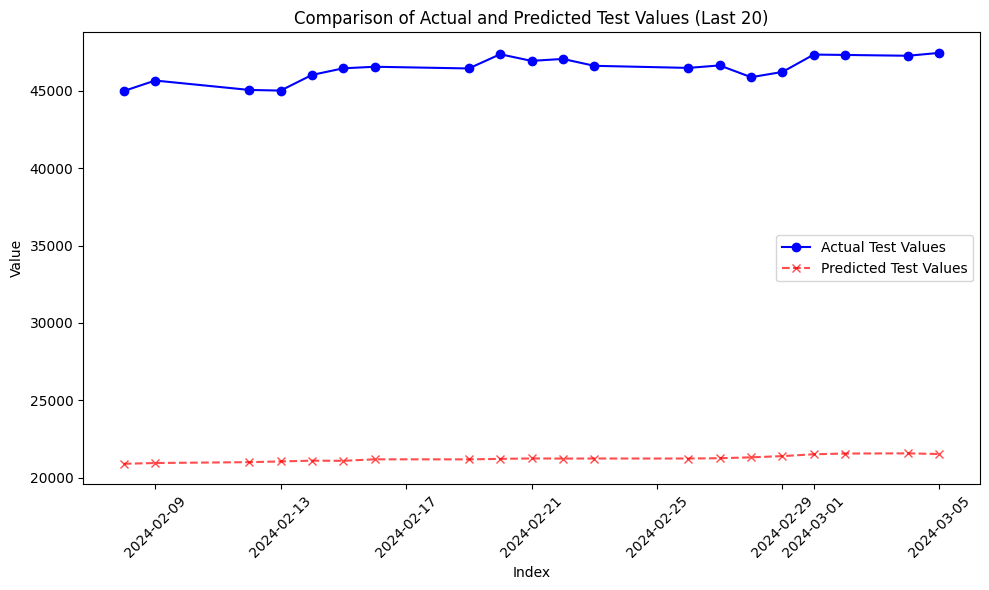

In [ ]:
y_pred_scaled = best_model.predict(X_val)

# Assuming y_pred_test and y_test_scaled have been defined as per previous steps

# Inverse transform the predictions and the actual test values to their original scale
y_pred_test_original = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

# Select the last 20 values from the original test set and the predictions
y_pred_last_20 = y_pred_test_original[-20:]
y_test_last_20 = y_test_original[-20:]


plt.figure(figsize=(10, 6))
plt.plot(index_last_20, y_test_last_20, label='Actual Test Values', marker='o', linestyle='-', color='blue')
plt.plot(index_last_20, y_pred_last_20, label='Predicted Test Values', marker='x', linestyle='--', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Test Values (Last 20)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability, if necessary
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


The analysis of the predictive model's performance, as reflected in the plot, reveals a significant disparity between the actual and predicted values. This discrepancy highlights the model's inability to capture the intricacies and temporal dependencies of the index's movements, which is crucial for forecasting in financial markets.

Despite a rigorous hyperparameter tuning process and the use of LSTM networks—which are typically well-suited for time-series prediction due to their ability to capture long-term dependencies—the model's predictions are flat and unresponsive to the actual data's trends. This suggests that the model may be suffering from underfitting, where the complexity of the model is insufficient to learn from the historical data. Consequently, the model appears to be defaulting to a naive approach, possibly reverting to the mean or another constant statistical measure, rather than adapting to fluctuations in the data.

The outcome is a model that is unsuitable for practical application, especially in the context of financial decision-making, where accuracy is paramount. To rectify this, one would need to explore more sophisticated modeling techniques, feature engineering, and possibly incorporating external factors that could influence the index's movements. Until the model can demonstrate a significant improvement in its predictive accuracy, as validated against an unseen test set, it cannot be relied upon for making informed trades or investment decisions in the financial markets.
